## 1. Создание модели

In [7]:
import torch
import torch.nn as nn


class DQN(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(3072, 256), nn.ReLU(), nn.Linear(256, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

## 2. Тренировка модели

### 2.1. Импорт библиотек

In [6]:
from PIL import Image
from collections import deque, namedtuple
import datetime
from itertools import count
import os
import shutil
import gymnasium as gym
from torchvision.utils import torch
import torch.nn as nn
import random
import envs
import numpy as np

*Пояснения:
- `PIL.Image` используется для создания и сохранения GIF,
- `deque` и `namedtuple` облегчают управление данными,
- `torch` и `nn` обеспечивают инструменты для нейронной сети,
- `envs` и `DQN` — это пользовательские модули для настройки среды и модели.

### 2.2. Создание буфера `Replay Memory`

Определим класс `MemoryReplay`, который будет хранить предыдущие состояния и действия агента. Он используется для "experience replay" — важного механизма для улучшения стабильности и эффективности обучения DQN.

In [8]:
Transition = namedtuple(
    "Transition", ("state", "action", "next_state", "reward", "terminated")
)


class MemoryReplay(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### 2.3. Определение класса Trainer

*Так как код получился объёмным, чтобы не занимать всю ячейку им, опишу здесь то, что происходит в каждой из частей класса.

Чтобы запустить тренировку модели достаточно выполнить следующую команду:
```bash
python train.py
```

*Для настройки параметров обучения следует изменить их необходимые значения в файле `train.py`

#### 2.3.1. Конструктор `__init__`

Этот блок инициализирует такие параметры как:
- буфер опыта,
- оптимизатор,
- функции для политики `eps-greedy`
- папки для сохранения результатов тренировки.

```python
class Trainer:
    def __init__(
        self,
        env: envs.Wrapper,
        policy_net: DQN,
        target_net: DQN,
        device: torch.device,
        n_episodes=10,
        lr=1e-4,
        batch_size=128,
        replay_size=100_000,  # experience replay's buffer size
        learning_start=50_000,  # number of frames before learning starts
        target_update_freq=10_000,  # number of frames between every target network update
        optimize_freq=4,
        gamma=0.99,  # reward decay factor
        # explore/exploit eps-greedy policy
        eps_start=1.0,
        eps_end=0.01,
        eps_decay=100_000,
    ):
        ...
        self.memory_replay = MemoryReplay(replay_size)
        ...

```


#### 2.3.2. Метод `_select_action`

```python
def _select_action(self, state: torch.Tensor) -> torch.Tensor:
    ...
```
Метод реализует выбор действия агентом с использованием `eps-greedy` стратегии, где `eps` управляет вероятностью случайного действия. Это важно для обеспечения баланса между исследованием и использованием изученной политики.

#### 2.3.3. Метод `_optimize`

```python
def _optimize(self):
    ...
```
Этот метод загружает батч данных из памяти, вычисляет целевые значения и обновляет параметры сети. Используется функция потерь SmoothL1Loss для уменьшения разности между предсказанными и целевыми значениями.

#### 2.3.4. Метод `train`

```pytohn
def train(self):
    ...
```
Основной метод обучения, который выполняет серии эпизодов. На каждом шаге выбирается действие, обновляется состояние, и, если нужно, оптимизируется сеть и обновляется целевая сеть (`target_net`).

#### 2.3.5. Метод `save_obs_result`

```python
def save_obs_result(self, episode_i: int, obs_arr: list[np.ndarray]):
    ...
```
Сохраняет каждый эпизод как GIF, используя `PIL.Image`, что позволяет визуализировать поведение модели.

### 2.4. Запуск обучения

Определяется устройство (CPU или GPU), создаётся среда и начинается обучение агента с использованием `Trainer`.

```python
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ...
    trainer = Trainer(env, policy_net, target_net, device=device)
    trainer.train()
```

## Результат обучения модели

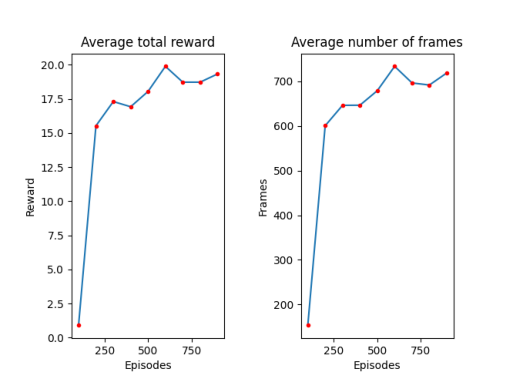

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Открытие изображения
img = mpimg.imread("./results/24-11-10-17-09/graphs.png")

# Отображение изображения
plt.imshow(img)
plt.axis('off')  # Скрыть оси
plt.show()

Выше представлен график обучения модели в ходе 1000 эпизодов. Награда определяется как количество препятствий, которые агент успешно преодолевает, прежде чем столкнется с одним из них. Лучшие параметры модели (на основе графика результатов) можно найти в файле `model.pth`.